In [1]:
import pacmap
import numpy as np
import cupy as cp  # CuPy for GPU array handling


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from numba import cuda

# Select GPU 2
cuda.select_device(3)

# Now all subsequent operations will run on GPU 2


<weakproxy at 0x7f65153fa360 to Device at 0x7f6515472850>

In [ ]:
import pandas as pd

# File paths
file_path1 = ".../20250707_connection_kidney_PBS_4_2_S4.spatial.csv.gz"

# Read the files
df = pd.read_csv(file_path1, compression='gzip')


In [ ]:
df.columns = ["Bead1_seq", "UMI", "Bead2_seq"]


In [6]:
df = df.drop_duplicates()


In [3]:
df.columns = ["Bead1_seq", "UMI", "Bead2_seq"]

# Verify the column names have been changed
print(df.columns)


Index(['Bead1_seq', 'UMI', 'Bead2_seq'], dtype='object')


In [4]:
import pandas as pd

def bead1_bead2_interaction(input_df):
    # Rename columns
    inside_df = input_df.copy()
    inside_df.columns = ["Bead1_seq", "UMI", "Bead2_seq"]

    # Group by Bead1_seq and Bead2_seq, then count unique UMI values
    n_umi_per_interaction_table = inside_df.groupby(['Bead1_seq', 'Bead2_seq']).size().reset_index(name='n_umi')

    # Group by Bead1_seq and count unique UMI values
    n_umi_per_bead1_table = n_umi_per_interaction_table.groupby('Bead1_seq').size().reset_index(name='n_umi')

    return {'n_umi_per_interaction': n_umi_per_interaction_table,
            'n_umi_per_bead1': n_umi_per_bead1_table}

# Sample usage:
# Assuming you have your data in df
# result = bead1_bead2_interaction(df)
# print(result['n_umi_per_interaction'])
# print(result['n_umi_per_bead1'])


In [5]:
output_list_patterns_Filter = bead1_bead2_interaction(df)


In [6]:
import numpy as np

# Assuming output_list_patterns_Filter is a dictionary and n_umi_per_interaction is a key pointing to a DataFrame
output_list_patterns_Filter['n_umi_per_interaction']['log_transformed'] = np.log10(output_list_patterns_Filter['n_umi_per_interaction']['n_umi'])


In [7]:
# Assuming output_list_patterns_Filter is a dictionary and n_umi_per_interaction is a key pointing to a DataFrame

filtered_df_filter = output_list_patterns_Filter['n_umi_per_interaction'][output_list_patterns_Filter['n_umi_per_interaction']['log_transformed'] >= .2]


In [9]:
n_umi_range = filtered_df_filter['n_umi'].agg(['min', 'max'])

print("Range of n_umi column:")
print(f"Min: {n_umi_range['min']}")

print(f"Max: {n_umi_range['max']}")



Range of n_umi column:
Min: 2
Max: 4206


In [27]:
filtered_df_filter

,Bead1_seq,Bead2_seq,n_umi,log_transformed
0,ACACCGTAAACAACCGAACCTCTCAGTCCGCT,CACTTCCACAGTCGAAAAGAGGCAGCTAGACTAGTC,2,0.301030
29,ACACCGTAAACAACCGAAGACTGGGGACTAGT,TTTCCGCTTCTTAGTGGCGACAAGAGCTATCGCTAAC,2,0.301030
33,ACACCGTAAACAACCGAATCGCCTGTCACTAG,ACTGACGAGGCAATCTCTTCTCGAGCTAAGTCCGCT,25,1.397940
35,ACACCGTAAACAACCGAATCGCCTGTCACTAG,AGTCAGTCGAATCCTTCACCGACTCTTGCTAGCTACTGA,8,0.903090
44,ACACCGTAAACAACCGAATCGCCTGTCACTAG,CCTCATCTCCTCATCTGGACGTATGCTAGACTGAGT,6,0.778151
...,...,...,...,...
19290230,TTTCCGCTTTTGTTCCGTTAACGCGACGTACCA,TCTTCCTTCCGCCTTAAGATCGGTAGCTATGGTCCAA,97,1.986772
19290239,TTTCCGCTTTTGTTCCGTTAACGCGTCGAACCA,TCTTCCTTCCGCCTTAAGATCGGTAGCTATGGTCCAA,2,0.301030
19290242,TTTCCGCTTTTGTTCCGTTGTTCCGTCGCTAAC,CCTGGAATACTGACGAAATGCAGCGCTATACCGTGA,37,1.568202
19290247,TTTCCGCTTTTGTTCCGTTGTTCCGTCGCTAAC,TCAGTAAGGTTCTGAGGCGTGCATAGCTAAGTCCGCT,3,0.477121


In [10]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

# Extract unique values
unique_bead1_seq = filtered_df_filter['Bead1_seq'].unique()
unique_bead2_seq = filtered_df_filter['Bead2_seq'].unique()

# Create mappings from sequences to indices
bead1_index = {seq: idx for idx, seq in enumerate(unique_bead1_seq)}
bead2_index = {seq: idx for idx, seq in enumerate(unique_bead2_seq)}

# Get the number of unique values
num_bead1_seq = len(unique_bead1_seq)
num_bead2_seq = len(unique_bead2_seq)

# Create a sparse matrix initialized with zeros (lil_matrix for easy assignment)
matrix_data_filter_sparse = lil_matrix((num_bead1_seq, num_bead2_seq), dtype=np.int64)

# Fill the sparse matrix with counts from the original DataFrame
for _, row in filtered_df_filter.iterrows():
    row_index1 = bead1_index[row['Bead1_seq']]
    row_index2 = bead2_index[row['Bead2_seq']]
    matrix_data_filter_sparse[row_index1, row_index2] = row['n_umi']

# Convert to csr_matrix after filling
matrix_data_filter_sparse = matrix_data_filter_sparse.tocsr()


In [12]:
matrix_data_filter_sparse

<384945x80556 sparse matrix of type '<class 'numpy.int64'>'
	with 4107492 stored elements in Compressed Sparse Row format>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/ru-auth/local/home/aabdul/miniconda3/envs/cell2loc_env2/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


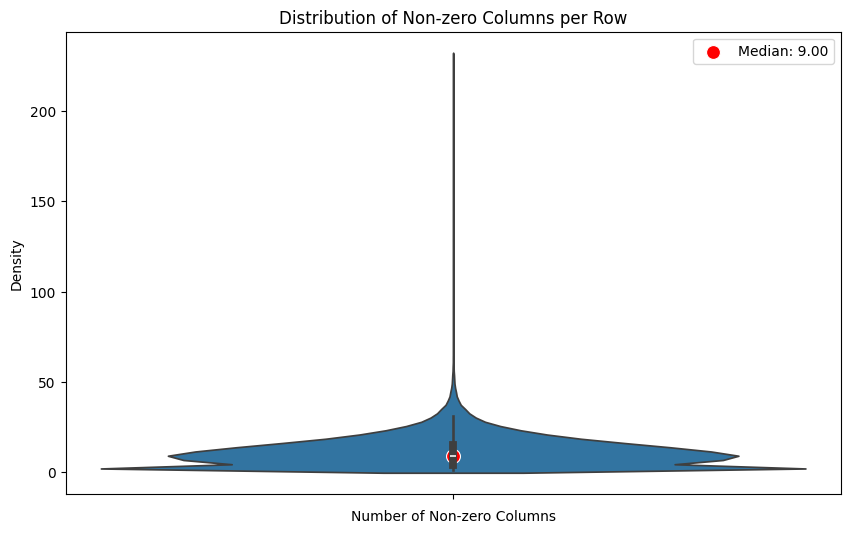

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Calculate the number of non-zero columns for each row (use getnnz to count non-zero elements in each row)
non_zero_counts = np.array(matrix_data_filter_sparse.getnnz(axis=1))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'NonZeroCounts': non_zero_counts})

# Calculate the median value
median_value = plot_df['NonZeroCounts'].median()

# Plotting the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=plot_df['NonZeroCounts'])

# Plot the median value as a point
sns.scatterplot(x=[0], y=[median_value], color='red', s=100, marker='o', label=f'Median: {median_value:.2f}')

# Add labels and title
plt.xlabel('Number of Non-zero Columns')
plt.ylabel('Density')
plt.title('Distribution of Non-zero Columns per Row')
plt.legend()

# Save the plot as a PDF file
plt.savefig('violin_plot.pdf')  # Make sure the path is correct and accessible

# Show the plot
plt.show()


In [17]:
matrix_data_filter_sparse

<384945x80556 sparse matrix of type '<class 'numpy.int64'>'
	with 4107492 stored elements in Compressed Sparse Row format>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [24]:
import numpy as np


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Assuming 'matrix_data_filter_sparse' is in CSR format

# Log1p transformation applied only to non-zero elements (sparse-compatible)
matrix_data_log1p = matrix_data_filter_sparse.copy()
matrix_data_log1p.data = np.log1p(matrix_data_log1p.data)

# Standardize the data (subtract mean and divide by std) in a sparse-aware manner
#scaler = StandardScaler(with_mean=False)  # Set `with_mean=False` because centering sparse data would make it dense
#matrix_data_standardized = scaler.fit_transform(matrix_data_log1p)

# Use TruncatedSVD for dimensionality reduction (sparse PCA alternative)
svd = TruncatedSVD(n_components=7000)  # Choose a suitable number of components
matrix_data_pca = svd.fit_transform(matrix_data_log1p)


In [ ]:

matrix_data_pca

In [ ]:
import numpy as np

# Save as .npy file
np.save('matrix_data_pca.npy', matrix_data_pca)



In [3]:
import numpy as np
import cudf
import cuml
import pandas as pd

# Load the .npy file
matrix_data_pca = np.load('matrix_data_pca.npy')


In [57]:
import numpy as np

# Save to a text file
np.savetxt('unique_bead1_seq_6500.txt', unique_bead1_seq, fmt='%s')


In [ ]:
from numba import cuda

# Select GPU 2
cuda.select_device(2)

# Now all subsequent operations will run on GPU 2


In [ ]:
matrix_data_pca.shape

In [ ]:
import cudf
import cuml



# Set the random seed for reproducibility
SEED = 42

# Create and fit the UMAP transformer using cuML
mapper = cuml.UMAP(
    n_neighbors=70,
    min_dist=.6,
    metric='cosine',
    random_state=SEED,
    n_epochs=700000,
    verbose=True,
    #spread=.3
)





# Fit and transform the data
coords = mapper.fit_transform(matrix_data_pca)

# `coords` will be a cuDF DataFrame containing the UMAP coordinates
#print(coords.head())


In [73]:
# `coords` will be a cuDF DataFrame containing the UMAP coordinates
print(coords.head())


AttributeError: 'numpy.ndarray' object has no attribute 'head'

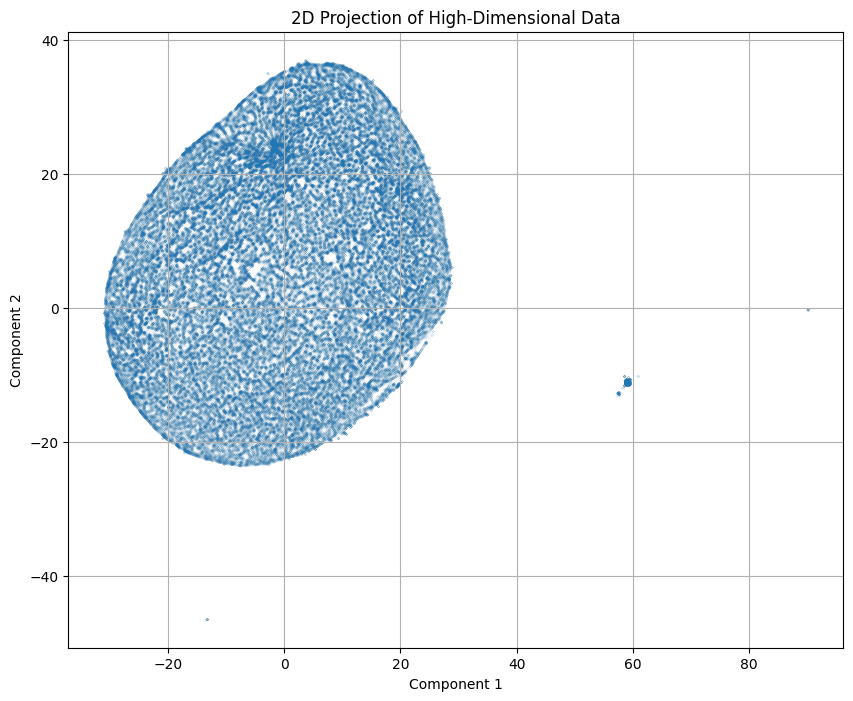

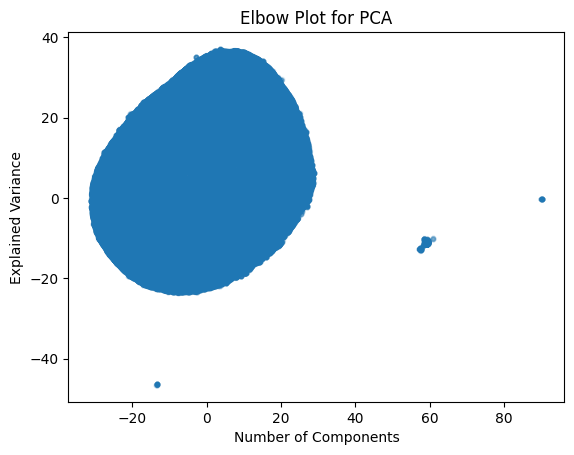

In [37]:
import matplotlib.pyplot as plt

# Access columns by their integer indices
#x = coords[0].to_numpy()  # Convert cuDF Series to NumPy array for plotting
#y = coords[1].to_numpy()


x = coords3[:, 0]  # First column corresponds to umap1
y = coords3[:, 1]  # Second column corresponds to umap2


plt.figure(figsize=(10, 8))  # Set the figure size
plt.scatter(x, y, alpha=1, s=.001)  # Create a scatter plot
plt.title('2D Projection of High-Dimensional Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()




# Save the plot as a PDF file
plt.scatter(x, y, alpha=0.1, s=10)  # Create a scatter plot

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot for PCA')
# Save the plot as a PDF file
plt.savefig('UMAP_map.pdf')  # Make sure the path is correct and accessible



In [23]:
coords.shape

NameError: name 'coords' is not defined

In [73]:
df = labels.to_frame(name='Labels')


In [74]:
coords.columns = ['UMAP1', 'UMAP2']
coords['clusterID'] = coords.index


In [75]:
merged_df = df.merge(coords, left_on='Labels', right_on='clusterID', how='left')


In [76]:
merged_df_pandas = merged_df.to_pandas()

umap_df = pd.DataFrame(merged_df_pandas, columns=['UMAP1','UMAP2'], index=unique_bead1_seq)


In [77]:
merged_df_pandas


x = merged_df_pandas["UMAP1"].to_numpy()
y = merged_df_pandas["UMAP2"].to_numpy()
# Create a DataFrame using x and y
umap_df = pd.DataFrame({'UMAP1': x, 'UMAP2': y}, index=unique_bead1_seq)





In [141]:
import pandas as pd
import numpy as np

# Assuming matrix_data_filter_sparse is a DataFrame or sparse matrix
# And coords is the DataFrame with the column coordinates

# Step 1: For each row, find the index of the column with the highest count
max_col_indices = matrix_data_filter_sparse.argmax(axis=1)  # Get index of max value for each row

# Step 2: Use the column indices to retrieve the corresponding coordinates
# Assuming coords is the DataFrame with the coordinates for the columns
row_coords = coords.iloc[max_col_indices].reset_index(drop=True)


ValueError: Data must be 1-dimensional

In [ ]:
x = coords[0].to_numpy()
y = coords[1].to_numpy()

# Create a DataFrame using x and y
umap_df = pd.DataFrame({'UMAP1': x, 'UMAP2': y})
umap_df


In [64]:
umap_df

,UMAP1,UMAP2
ACACCGTAAACAACCGAACCAGGTAGCCTTCA,40.110615,9.163864
ACACCGTAAACAACCGAACGGAAGGATTGAGC,-7.958420,34.466953
ACACCGTAAACAACCGAAGACTGGTACAGGTC,-4.091015,-4.785166
ACACCGTAAACAACCGAATCGCCTTAGGCTGA,-8.129501,-25.263470
ACACCGTAAACAACCGACAATGCCGATCAGCA,-0.679398,-47.738911
...,...,...
TTTCCGCTTTTGTTCCGGTTCCAAGGATCAGCA,-23.332191,-17.395599
TTTCCGCTTTTGTTCCGTACGGTCTGCTGACAT,-14.213711,-27.862282
TTTCCGCTTTTGTTCCGTCATGCGTACGGCTAC,-22.541706,-7.441801
TTTCCGCTTTTGTTCCGTCGCATTCACCGCTAT,13.059509,-35.326363


In [165]:
# Flatten the arrays to make sure they are 1D
x_coords = umap_df['UMAP1'].to_numpy()[max_col_indices].ravel()  # Flatten to ensure it's 1D
y_coords = umap_df['UMAP2'].to_numpy()[max_col_indices].ravel()  # Flatten to ensure it's 1D


In [166]:
x_coords

array([-8.459526 ,  1.5611725,  4.9603653, ..., -2.8882294,  0.1324501,
       -4.312908 ], dtype=float32)

In [167]:

# Create a DataFrame using x and y
umap_df = pd.DataFrame({'UMAP1': x_coords, 'UMAP2': y_coords}, index=unique_bead1_seq)


In [ ]:
umap_df

In [139]:
import pandas as pd
import numpy as np

# Assuming matrix_data_filter_sparse is a DataFrame or sparse matrix
# And coords is the DataFrame with the column coordinates

# Step 1: For each row, find the index of the column with the highest count
max_col_indices = matrix_data_filter_sparse.argmax(axis=1)  # Get index of max value for each row

row_coords = umap_df.iloc[max_col_indices].reset_index(drop=True)

# Step 3: Create a new DataFrame with the same number of rows as the matrix and assign the coordinates
new_row_coords = pd.DataFrame({
    'x_coord': row_coords.iloc[:, 0].values,  # Assign x-coordinates
    'y_coord': row_coords.iloc[:, 1].values   # Assign y-coordinates
})

# Step 4: Display the new coordinates for the rows
print(new_row_coords)


ValueError: Data must be 1-dimensional

In [65]:
x = coords[0].to_numpy()
y = coords[1].to_numpy()

# Create a DataFrame using x and y
umap_df = pd.DataFrame({'UMAP1': x, 'UMAP2': y}, index=unique_bead1_seq)



AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [32]:
x = coords3[:, 0]  # First column corresponds to umap1
y = coords3[:, 1]  # Second column corresponds to umap2
umap_df = pd.DataFrame({'UMAP1': x, 'UMAP2': y}, index=unique_bead1_seq)



In [33]:
coords.shape

NameError: name 'coords' is not defined

In [34]:
umap_df

,UMAP1,UMAP2
ACACCGTAAACAACCGAACCTCTCAGTCCGCT,58.393044,-10.839462
ACACCGTAAACAACCGAAGACTGGGGACTAGT,-23.962158,-2.391315
ACACCGTAAACAACCGAATCGCCTGTCACTAG,-24.220589,13.053631
ACACCGTAAACAACCGACCGAATCGCTACTGA,-25.815033,1.485252
ACACCGTAAACAACCGACCGAATCGTCACTGA,-26.017925,1.564335
...,...,...
TTTCCGCTTTTGTTCCGTCGAACCAGAGTGACT,-20.917545,11.910738
TTTCCGCTTTTGTTCCGTGAGGATGTCGATGAC,-6.277611,-17.486618
TTTCCGCTTTTGTTCCGTTAACGCGACGTACCA,-24.646420,-7.867897
TTTCCGCTTTTGTTCCGTTAACGCGTCGAACCA,-24.740726,-7.910671


In [35]:
mkdir /rugpfs/fs0/cao_lab/scratch/aabdul/projects/AA_20250922_BeadArraySeq_84/maps_coords

In [36]:


#FO1_2
# Specify your desired file path and name
file_path = "//rugpfs/fs0/cao_lab/scratch/aabdul/projects/AA_20250922_BeadArraySeq_84/maps_coords/PBS_4_2.csv"

# Save the DataFrame to a CSV file
umap_df.to_csv(file_path)

# Optionally print a message to indicate the process is done
print(f"Data saved to {file_path}")



Data saved to //rugpfs/fs0/cao_lab/scratch/aabdul/projects/AA_20250922_BeadArraySeq_84/maps_coords/PBS_4_2.csv
